<a href="https://colab.research.google.com/github/bpizarrogalleguillos/IAmetodologia2025/blob/main/DeepLearning_radiograf%C3%ADas_t%C3%B3rax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/

In [ ]:
# Crear carpeta oculta .kaggle
!mkdir -p ~/.kaggle

# Mover kaggle.json al directorio correcto
!cp kaggle.json ~/.kaggle/

# Establecer permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 📥 Descargar dataset desde Kaggle (Chest X-Ray Pneumonia)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [ ]:
# 🗃️ Descomprimir el archivo ZIP
!unzip chest-xray-pneumonia.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  

In [ ]:
!ls

chest_xray  chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
import os
import shutil
import tempfile
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

# **Verify and Correct Directory Paths**

# Check if 'chest_xray' directory exists in the current directory
if not os.path.exists('chest_xray'):
    # If not, check if it exists one level up
    if os.path.exists('../chest_xray'):
        # If found, adjust paths to point to the correct location
        train_dir = '../chest_xray/train/'
        test_dir = '../chest_xray/test/'
        val_dir = '../chest_xray/val/'
    else:
        # If 'chest_xray' is not found, raise an error
        raise FileNotFoundError("The 'chest_xray' directory was not found in the current or parent directory.")
else:
    # If 'chest_xray' is found in the current directory, use these paths:
    train_dir = 'chest_xray/train/'
    test_dir = 'chest_xray/test/'
    val_dir = 'chest_xray/val/'

class_names0 = sorted([x for x in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, x))])
class_names = ['NORMAL', 'PNEUMONIA']

num_class = len(class_names)

image_files = [[os.path.join(train_dir, class_name, x)
               for x in os.listdir(os.path.join(train_dir, class_name))]
               for class_name in class_names]
test_image_files = [[os.path.join(test_dir, class_name, x)
                    for x in os.listdir(os.path.join(test_dir, class_name))]
                    for class_name in class_names]
val_image_files = [[os.path.join(val_dir, class_name, x)
                    for x in os.listdir(os.path.join(val_dir, class_name))]
                    for class_name in class_names]

print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
print(image_file_list[0:10])

test_image_file_list = []
test_image_label_list = []
for i, class_name in enumerate(class_names):
    test_image_file_list.extend(test_image_files[i])
    test_image_label_list.extend([i] * len(test_image_files[i]))
test_num_total = len(test_image_label_list)
print(test_image_file_list[0:10])

val_image_file_list = []
val_image_label_list = []
for i, class_name in enumerate(class_names):
    val_image_file_list.extend(val_image_files[i])
    val_image_label_list.extend([i] * len(val_image_files[i]))
val_num_total = len(val_image_label_list)
print(val_image_file_list[0:10])

['chest_xray/train/NORMAL/NORMAL2-IM-0408-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1288-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1089-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1064-0001.jpeg', 'chest_xray/train/NORMAL/IM-0727-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1376-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1308-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1277-0001.jpeg', 'chest_xray/train/NORMAL/IM-0276-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0493-0001.jpeg']
['chest_xray/test/NORMAL/NORMAL2-IM-0302-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0219-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0107-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0252-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0285-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0348-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0326-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0292-0001.jpeg', 'chest_xray/test/NORMAL/NORMAL2-IM-0362-0001.jpeg', 'chest_xray/test

In [ ]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 5216
Image dimensions: 1978 x 1766
Label names: ['NORMAL', 'PNEUMONIA']
Label counts: [1341, 3875]


In [ ]:

def display_random_images(num_images_to_display):
  """Displays a grid of random images from the dataset.

  Args:
    num_images_to_display: The number of images to display.
  """

  # Calculate grid dimensions based on the number of images
  num_cols = int(np.ceil(np.sqrt(num_images_to_display)))
  num_rows = int(np.ceil(num_images_to_display / num_cols))

  # Create subplots with calculated dimensions
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

  # Flatten the axes array for easier iteration
  axes = axes.flatten()

  # Select random image indices
  random_indices = np.random.randint(num_total, size=num_images_to_display)

  # Iterate and display images
  for i, k in enumerate(random_indices):
      im = Image.open(image_file_list[k])
      arr = np.array(im)
      axes[i].imshow(arr, cmap='gray', vmin=0, vmax=255)  # Display on the current subplot
      axes[i].set_xlabel(class_names[image_label_list[k]])  # Set the label
      axes[i].set_xticks([])  # Remove x-axis ticks
      axes[i].set_yticks([])  # Remove y-axis ticks

  # Hide any extra subplots if necessary
  for j in range(num_images_to_display, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

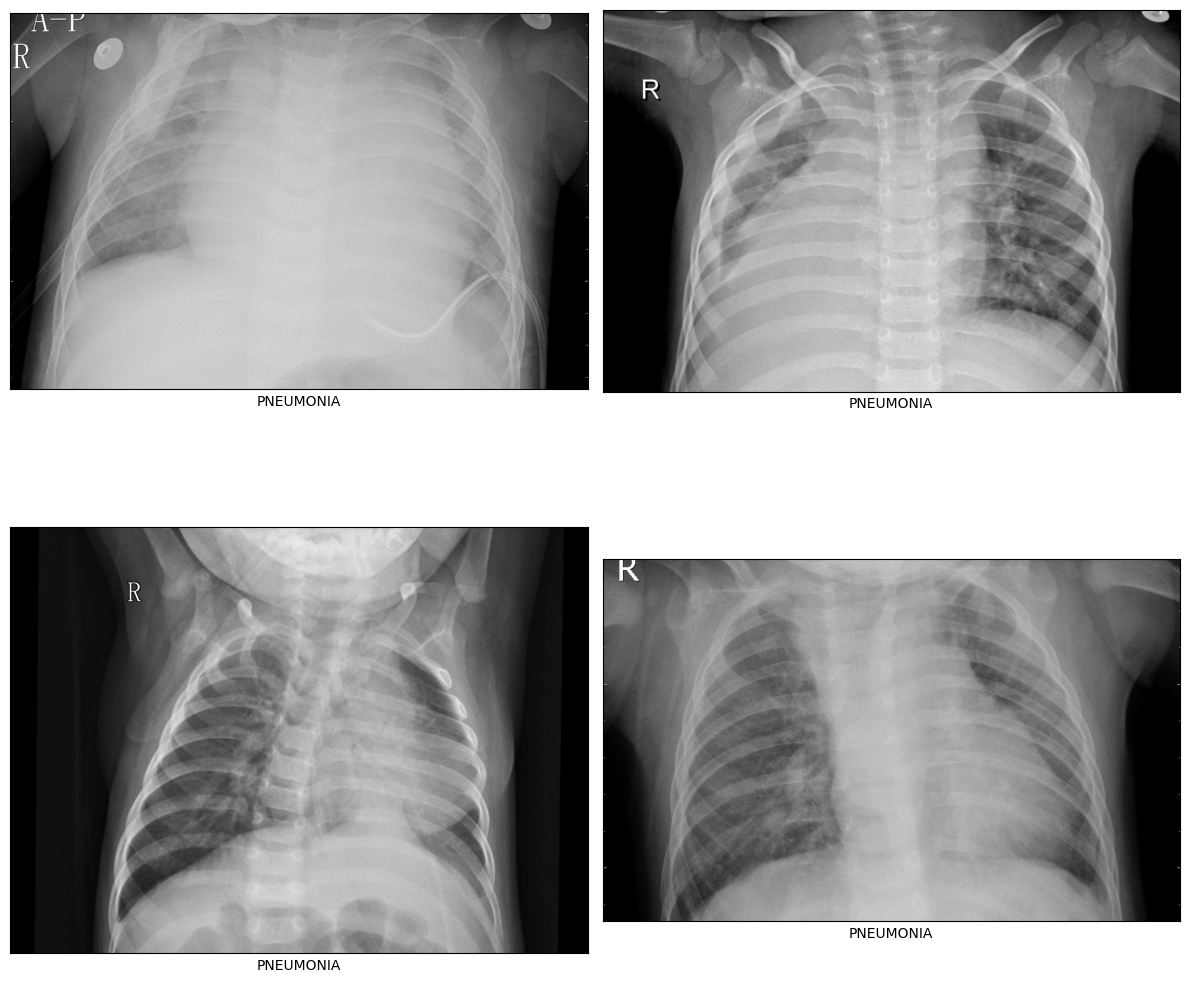

In [ ]:
display_random_images(4)  # To display 20 random images

# Train , validation, test

In [ ]:
#valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

#rann = np.random.random()
for i in range(val_num_total):
        valX.append(val_image_file_list[i])
        valY.append(val_image_label_list[i])

for i in range(test_num_total):
        testX.append(test_image_file_list[i])
        testY.append(test_image_label_list[i])

for i in range(num_total):
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX),len(testX))

5216 16 624


In [ ]:
class MyResize(Transform):
    def __init__(self, size=(80,80)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [ ]:
from monai.transforms import EnsureChannelFirst, Compose, LoadImage, Resize, ScaleIntensity, ToTensor

train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(),
    EnsureChannelFirst(),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(),
    EnsureChannelFirst(),
    ToTensor()
])

test_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    ScaleIntensity(),
    MyResize(),
    EnsureChannelFirst(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)  # Use num_class for to_onehot

In [ ]:
class MyResize(Transform):
    def __init__(self, size=(80,80)):
        self.size = size
    def __call__(self, inputs):
        # Ensure the input is on the CPU and converted to a NumPy array
        image_np = inputs.cpu().numpy() if isinstance(inputs, torch.Tensor) else np.array(inputs)

        # Apply cv2.resize
        image2 = cv2.resize(image_np, dsize=(self.size[1], self.size[0]), interpolation=cv2.INTER_CUBIC)

        # Return the resized image as a PyTorch tensor
        # Move the tensor to the appropriate device (CPU or GPU) based on your training setup.
        return torch.from_numpy(image2).to(inputs.device)  # Use inputs.device

In [ ]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

test_ds = MedNISTDataset(testX, testY, test_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=2)

NameError: name 'MedNISTDataset' is not defined

In [ ]:
# Check if CUDA is available
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# ... (rest of your code) ...

device = torch.device("cuda:0")   # "cuda:0","cpu"
model = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 20
val_interval = 1

CUDA is available. Using GPU.


In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:     #### error here
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')

            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20


NameError: name 'train_loader' is not defined